### INDUCTION
This analysis is to estimate the efficiency of the relationship between the inputs and outputs. With the same input, the higher the output, the higher the efficiency. Conversely, to produce the same output, the lower input, the higher efficiency.
If you are relevant to `Microeconomic theories`, you properly know the Cobb-Douglas production function, which performs a particular equation between two factors (capital input and labor input) and total production (the output). In the case of the complicated inputs and output leading to the unknown product function, the efficiency can not be estimated.\
`Data Envelopment Analysis` (DEA) is a methodology to solve this problem. It estimates the production function with a non-paramistics approach.\n
For more information about DEA, I would like to highly recommend the following references, also appreciate the authors who helped me complete this analysis:
- The quick overview of DEA and the Python function code: https://github.com/gary60405/Data-Envelopment-Analysis-Tutorial
- The original methodology of DEA: Measuring the efficiency of decision-making units (Charnes, Cooper, and Rhodes, 1978)

In [12]:
# let import necessary packages and defined functions

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from utils import getMinOE, getMinTE  # defined by gary60405
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

### DATASET
The dataset is from Kaggle: https://www.kaggle.com/datasets/harrimansaragih/dummy-advertising-and-sales-data/
It is about the relationship between the Marketing promotion budget and actual sales.\
The budget considered as inputs contains:
- TV promotion budget (mil USD)
- Social Media promotion budget (mil USD)
- Radio promotion budget (mil USD)
- Influencer: (optional) Mega / Macro / Nano / Micro

The only output is the actual sales.

To wrap up, The problem we need to solve is which promotion program is highly efficient, uses less budget on Marketing but makes more sales.

In [21]:
df = pd.read_csv("./data/Dummy Data HSS.csv")
df[["TV","Radio","Social Media","Sales"]] = df[["TV","Radio","Social Media","Sales"]].fillna(0) # the null cells are supposed to have no budget or sales
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True) # each row of dataset is supposed to be a promotion campaign
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4572 entries, 0 to 4571
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   TV            4572 non-null   float64
 1   Radio         4572 non-null   float64
 2   Social Media  4572 non-null   float64
 3   Influencer    4572 non-null   object 
 4   Sales         4572 non-null   float64
dtypes: float64(4), object(1)
memory usage: 178.7+ KB


So, we have more than 4500 promotion campaigns, and the inputs are all continuous, except Influencers. It has 4 values, and I am not sure which one is more costly than the remain.\
To make an easier decision, I will place this input outside of DEA, and it will return after DEA results as a validation dimension. I will figure out which influencer can pull more efficient promotion campaigns.

For DEA, we need to define some parameters:
- Decision-making units (DMUs): each DMU is a promotion campaign
- The inputs: TV, Radio, Social Media budget
- The outputs: only actual sales

There are 3 ways to evaluate the efficiency:
- `Constant Returns to Scales` (CRS): the quantity of output increase is proportional to the input increase. Then, the relationship between the input and output shapes a line going up.
- `Variable Returns to Scales` (VRS): the relationship is not a line, but a curve. It contains two stages:
    - `Increase Returns to Scales` (DRS): In the short run, the quantity of output increase is larger than the input increase.
    - `Decrease Returns to Scales` (DRS): In the long run, the quantity of output increase is less than the input increase.
- Most productivity scale size (MPSS): it appears when CRS and VRS meet each other. In other words, the line shaped by CRS approaches the curve shaped by VRS

Actually, CRS is the original method developed by `Charnes, Cooper, and Rhodes` (1978), and is also called the CCR model. In 1984, `Banker, Charnes, and Cooper` proposed VRS based on the limitation of CRS, which is also called the BBC model.

Each promotion campaign (DMU) receives 3 efficiency ratios:
- `Overall Efficiency` (OE): estimated by the CRS model
- `Technical Efficiency` (TE): estimated by the VRS model
- `Scale efficiency` (SE): decomposed by OE and TE, which is calculated as OE divided by TE

In [22]:
K = df.index.tolist() # DMUs
I = ["TV","Radio","Social Media"] # name of inputs
J = ["Sales"] # name of outputs
X = df[I].to_dict() # input data
Y = df[J].to_dict() # output data
dea_output = []

def running_dea(k):
    _, OE_val = getMinOE(r=k,K=K,I=I,J=J,X=X,Y=Y) # to evaluate Constant Returns to scales (CRS) 
    _, TE_val = getMinTE(r=k,K=K,I=I,J=J,X=X,Y=Y) # to evaluate Variable Returns to Scales (VRS)
    SE_val = OE_val / TE_val
    dea_output.append({
            'id':K[k],
            'OE':OE_val,
            'TE':TE_val,
            'SE':SE_val
        })

In [23]:
rerun_dea = False # if True, the whole process of DEA will run again. Only False when we already save the DEA results to a local file for further repeated steps

if rerun_dea:
    dea_output = []
    # using ThreadPoolExecutor to reduce loop time, it actually depends on the computer memory
    with ThreadPoolExecutor(max_workers=100) as thread:
        thread.map(running_dea, tqdm(range(len(K))))
    
    # let merge DEA results into the df
    df_output = pd.concat([df.drop(columns=["OE","TE","SE"], errors="ignore"), pd.DataFrame(dea_output).set_index('id')], axis=1)
    df_output.to_csv('./data/DEA_MKT_Efficiency.csv', index=False)
else:
    df_output = pd.read_csv('./data/DEA_MKT_Efficiency.csv')

100%|██████████| 4572/4572 [43:09<00:00,  1.77it/s]  


Text(0.5, 1.0, 'SE Histogram')

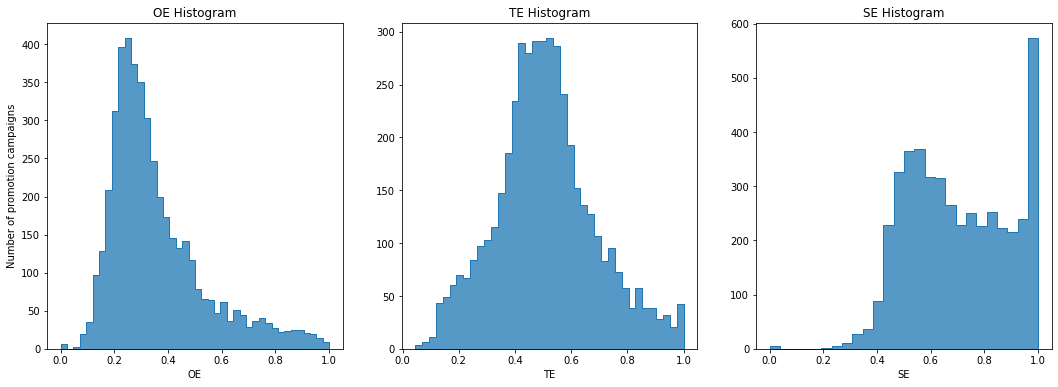

In [45]:
# let's make histograms on 3 efficiency ratios
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18,6))

ax = axs[0]
sns.histplot(data=df_output, x="OE", element="step", ax=ax)
ax.set_ylabel("Number of promotion campaigns")
ax.set_title("OE Histogram")

ax=axs[1]
sns.histplot(data=df_output, x="TE", element="step", ax=ax)
ax.set_ylabel("")
ax.set_title("TE Histogram")

ax=axs[2]
sns.histplot(data=df_output, x="SE", element="step", ax=ax)
ax.set_ylabel("")
ax.set_title("SE Histogram")

In [53]:
# there are some cases with zero SE
# unsurprisingly, those cases have zero sales
df_output[df_output["SE"] == 0]

,TV,Radio,Social Media,Influencer,Sales,OE,TE,SE
208,77.0,25.598379,5.514787,Nano,0.0,0.0,0.051578,0.0
214,100.0,36.466753,5.635992,Mega,0.0,0.0,0.044654,0.0
221,74.0,24.220634,0.285898,Micro,0.0,0.0,0.134698,0.0
226,19.0,8.726783,0.497838,Mega,0.0,0.0,0.332713,0.0
231,22.0,6.809752,0.011451,Macro,0.0,0.0,0.634384,0.0
236,27.0,1.384415,2.398129,Nano,0.0,0.0,0.289232,0.0


As the above histograms show, most promotion campaigns get OE in range of 0.2-0.4, TE from 0.4 to 0.6, and SE at a peak of 1.0.\
To preserve the scalability, I choose SE as the primary criterion to evaluate the promotion campaign's efficiency.\

Now, let's verify the role of DEA in the promotion campaigns efficiency. I will choose some promotion campaigns for comparison.

In [61]:
# cases having similar output (from 150 to 159 mil USD), but lower inputs make higher efficiency
# when I sort results by SE, it is easy to realize that the TV budget is also similar, but the case with SE 1.0 gets much lower both Radio and Social Media budget than the case with SE about 0.5
df_output[
    (df_output["SE"] > 0.5) &
    (df_output["Sales"] // 10 == 15)
].sort_values("SE")

,TV,Radio,Social Media,Influencer,Sales,OE,TE,SE
1524,45.0,13.485326,5.942776,Nano,157.881477,0.206075,0.410351,0.502192
3781,45.0,14.184604,5.545421,Macro,153.578704,0.193461,0.384929,0.502588
2196,42.0,15.025210,4.472240,Macro,151.755395,0.192324,0.380892,0.504931
1626,44.0,13.791944,4.325957,Macro,155.787445,0.205944,0.405331,0.508089
1141,45.0,12.224536,6.078835,Nano,159.171002,0.223141,0.435429,0.512462
...,...,...,...,...,...,...,...,...
1118,45.0,17.943591,0.169791,Macro,158.764739,0.833514,0.849118,0.981624
290,45.0,15.537329,0.125813,Mega,157.687298,0.856067,0.871350,0.982461
4284,43.0,5.738748,0.043311,Mega,152.051551,0.921324,0.937376,0.982876
4328,45.0,16.610410,0.000977,Mega,155.233634,0.932995,0.947152,0.985052


We completely find which promotion campaigns are better. Under the business view, we are actually able to figure out more insights and common characteristics of the most efficient campaigns. They could be the customer segmentation, the occasional time... Then, we can learn and utilize the successful historical campaigns to make similar or even better ones.\
However, due to the limitation of the dataset, I paused the analysis here. Maybe I could do some stuff to know which influencers get more efficient campaigns.

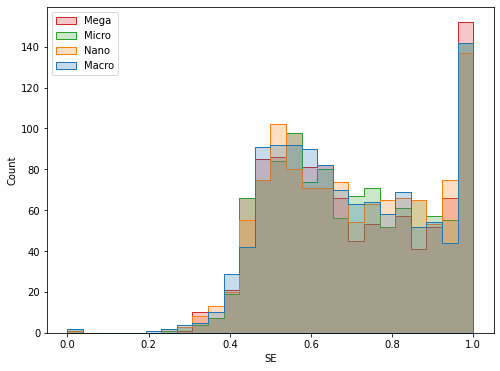

In [74]:
# There seems to be no clear difference between influencers
plt.figure(figsize=(8,6))
sns.histplot(data=df_output, x="SE", hue="Influencer", element="step")
plt.legend(df_output["Influencer"].unique(), loc="upper left")

In [76]:
df_output.groupby("Influencer", as_index=False).agg(
    count=("SE","count"),
    min=("SE","min"),
    avg=("SE","mean"),
    med=("SE","median"),
    std=("SE","std"),
    max=("SE","max")
)

,Influencer,count,min,avg,med,std,max
0,Macro,1122,0.0,0.698574,0.667766,0.190072,1.0
1,Mega,1158,0.0,0.694179,0.674566,0.185079,1.0
2,Micro,1153,0.0,0.705932,0.693725,0.186727,1.0
3,Nano,1139,0.0,0.704152,0.692939,0.185259,1.0
